# opinion spread in a network model (with Mesa)

In [1]:
import random
import time, enum, math
import numpy as np
import pandas as pd
import pylab as plt
import networkx as nx
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector

In [2]:
# setup the opinion range of the agents
class opinion(enum.IntEnum):
    disagree = 0
    believe = 1
    unsure = 2

In [3]:
# stochasticity generator

def stochastic(probability):
    
    random_number = random.uniform(0, 1)
    
    if probability == 0:
        return False
    elif random_number < probability:
        return True
    else:
        return False

In [4]:
# setup agent properties
class my_agent(Agent):

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.state = opinion.disagree  # by default agents disagree -> the first one with believe is then given in the model -> need to think of how to handle unsure

    # listen to neighbors and stochastically change opinion accordingly
    def listen(self):

        # find neighbors
        neighbors = self.model.grid.get_neighbors(self.pos, include_center=False)

        if len(neighbors) > 0:
            
            for neighbor in neighbors:  #maybe we should shuffle the neighbors iterator here

                neighbor_obj = self.model.schedule.agents[neighbor]

                # if else for possible state transitions depending on the neighbor 
                # NOTE: this could probably be done better, but does the job for now
                # will expand this when we know exactly how opinion change is mediated, i.e. by what variables etc.
                # here "unsure" neighbors have no impact on the own opinion
                if self.state != neighbor_obj.state:
                                                        
                    #print("this is the agents own opinion " + str(self.state))
                    #print("this is the neighbors opinion " + str(neighbor_obj.state))
                    
                    if self.state == opinion.disagree and neighbor_obj.state == opinion.believe:
                            
                            # stochastically change state to "unsure"
                            if stochastic(model.p_opinion_change):
                                self.state = opinion.unsure            
                        
                    elif self.state == opinion.believe and neighbor_obj.state == opinion.disagree:
                            
                            # stochastically change state to "unsure"
                            if stochastic(model.p_opinion_change):
                                self.state = opinion.unsure 
                                            
                    elif self.state == opinion.unsure:
                        
                        if neighbor_obj.state == opinion.disagree:
                            
                            # stochastically change state to "disagree"
                            if stochastic(model.p_opinion_change):
                                self.state = opinion.disagree 
                        
                        elif neighbor_obj.state == opinion.believe:
                            
                            # stochastically change state to "believe"
                            if stochastic(model.p_opinion_change):
                                self.state = opinion.believe     
                        
                    #print("@ end of listen: this is the agents own opinion " + str(self.state))
                    #print("@ end of listen: this is the neighbors opinion " + str(neighbor_obj.state))               
                    
                
    # step funciton, i.e. the actions an agent can take when the model evolves for a time step
    def step(self):
        self.listen()
        

## network model

In [5]:
class network_model(Model):
       
    def __init__(self, population_size = 100, n_initial_believers = 3, avg_node_degree = 3, p_opinion_change = 1):
                
        # build the network:
        self.num_nodes = population_size  
        prob = avg_node_degree / self.num_nodes
        self.G = nx.erdos_renyi_graph(n = self.num_nodes, p = prob)
        self.grid = NetworkGrid(self.G)
        
        
        # scheduling
        self.schedule = RandomActivation(self)
        self.running = True # I assume this is to make it run?
        
        self.initial_believers = 1 #this could be changed and doesnt need to be here
        
        self.p_opinion_change = p_opinion_change # chance that listening changes opinion

        # populate network with agents
        for i, node in enumerate(self.G.nodes(), start = 1):
            a = my_agent(i, self) 
            self.schedule.add(a)
            # add agent
            self.grid.place_agent(a, node) # hence agent id = agent pos
            
        # make some agents believers from the start
        initial_believers = random.sample(self.schedule.agents, n_initial_believers)
       
        for i in initial_believers:

            i.state = opinion.believe
           
        # something to collect data into    
        self.datacollector = DataCollector(
            agent_reporters={"State": "state"})

    # model step (same as agent step but for the model, i.e. the model collects data at every step, etc.)
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [6]:
# initiate model


model = network_model(population_size = 100, n_initial_believers = 30, avg_node_degree = 3, p_opinion_change = 1)

# run the model steps times 
steps = 1
for i in range(steps):
    model.step()

model

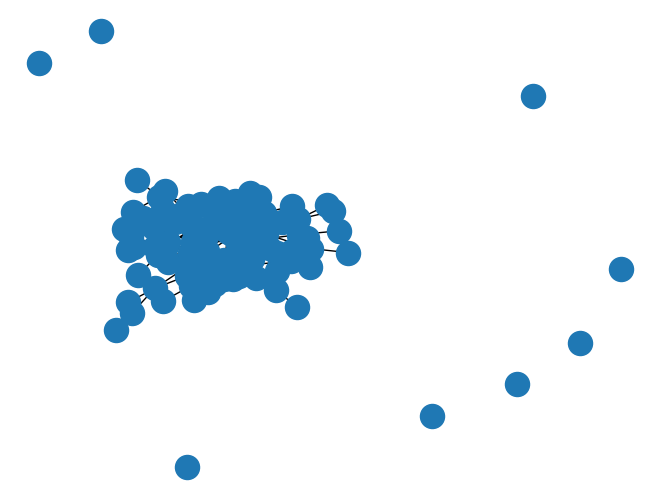

In [7]:
# quick visual check of the network structure:
nx.draw(model.G) 

# running the model and data collection stuff

In [8]:
# convenience function to initiate and run model (parameter exploration in mind)
def initiate_and_run_model(steps):

    model = network_model(population_size = 100, n_initial_believers = 20, avg_node_degree = 3, p_opinion_change = 1)
    
    for i in range(steps):
        model.step()
    
    return model

model = initiate_and_run_model(10)

In [9]:
#convenience function to collect plotable data
def sum_agents(model):
    
    agent_data = model.datacollector.get_agent_vars_dataframe()
    # sum up different opinions each (time) step
    agents_summed = pd.pivot_table(agent_data.reset_index(), index = 'Step', columns = 'State', aggfunc = np.size, fill_value = 0)    
    # relabel
    labels = ['Disagree','Believer','Unsure']
    agents_summed.columns = labels[:len(agents_summed.columns)]
    return agents_summed

sum_agents(model)

,Disagree,Believer,Unsure
Step,,,
0,80,20,0
1,67,11,22
2,76,12,12
3,78,10,12
4,79,10,11
5,80,10,10
6,80,9,11
7,81,9,10
8,81,9,10


In [10]:
#convenience function to collect plotable data in an array
def sum_agents(model):
    
    agent_data = model.datacollector.get_agent_vars_dataframe()
    # sum up different opinions each (time) step
    agents_summed = pd.pivot_table(agent_data.reset_index(), index = 'Step', columns = 'State', aggfunc = np.size, fill_value = 0)    
    # relabel
    labels = ['Disagree','Believer','Unsure']
    agents_summed.columns = labels[:len(agents_summed.columns)]
    return agents_summed

sum_agents(model)

,Disagree,Believer,Unsure
Step,,,
0,80,20,0
1,67,11,22
2,76,12,12
3,78,10,12
4,79,10,11
5,80,10,10
6,80,9,11
7,81,9,10
8,81,9,10


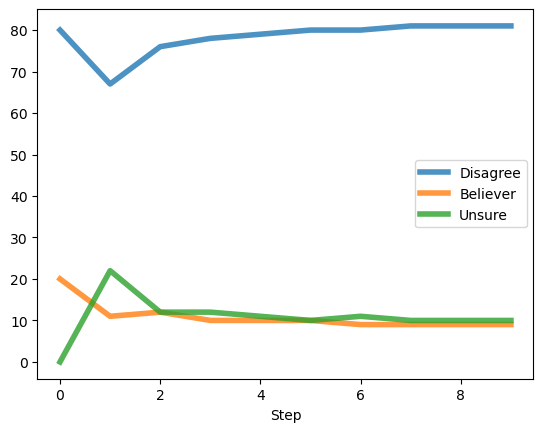

In [11]:
# quick visual sanity check on opinion evolution
def plot_agent_opinion(model):
    steps = model.schedule.steps
    X = sum_agents(model)
    X.plot(lw = 4, alpha = 0.8)
    
plot_agent_opinion(model)

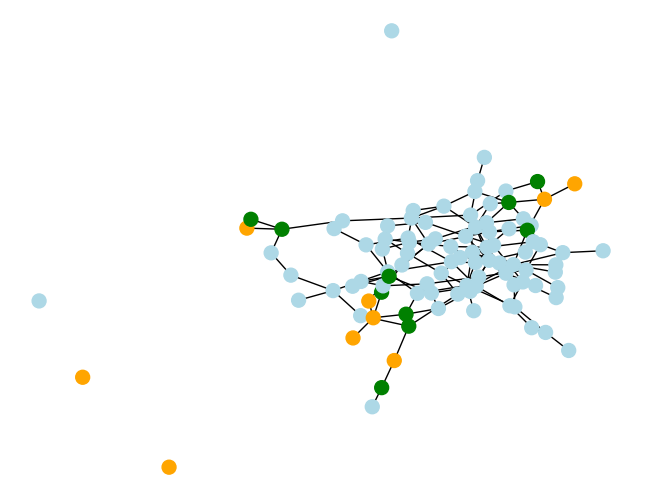

In [12]:
# nicer network figure where nodes are color coded  
     
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

color_code = ListedColormap(["lightblue", "orange", "green",])

states = [int(i.state) for i in model.grid.get_all_cell_contents()]

colors = [color_code(i) for i in states]
    
nx.draw(model.G, node_size = 100, edge_color = 'black', node_color = colors)


## Small for loop to evaluate phases

### 1 loop just with the evaluation method that chris introduced 2 loop with a "data extraction" strategy= a bad array

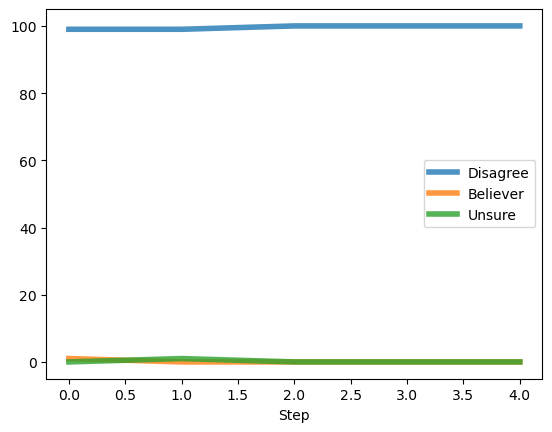

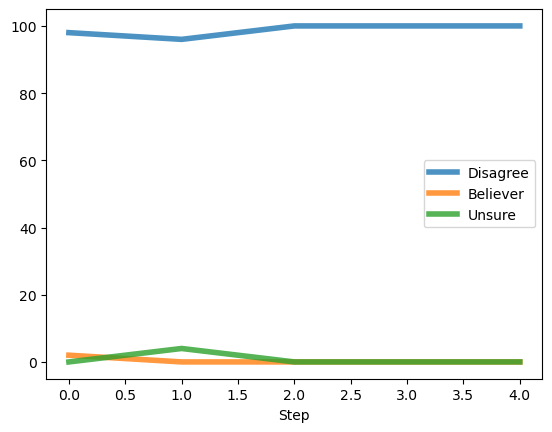

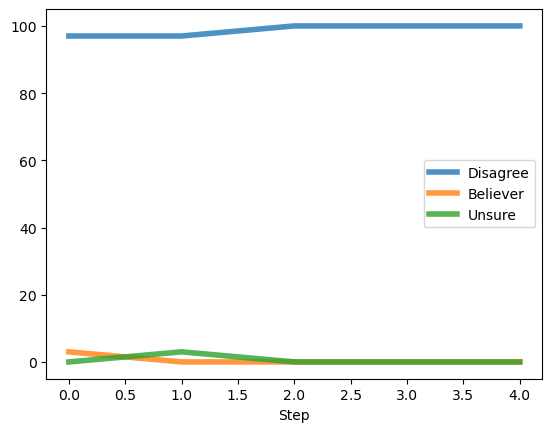

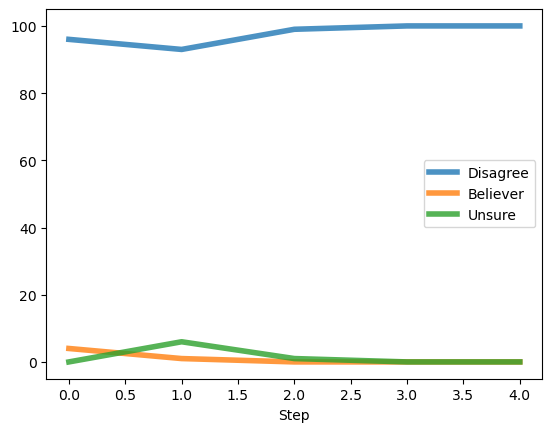

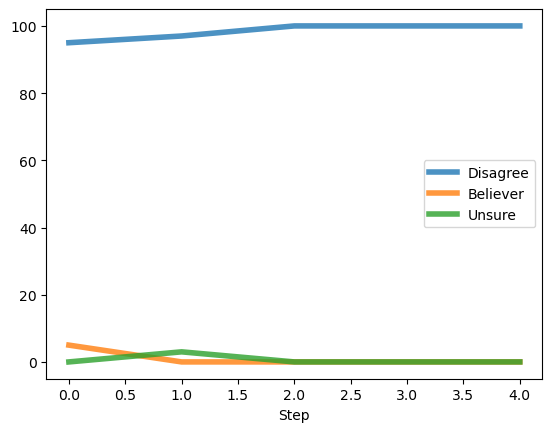

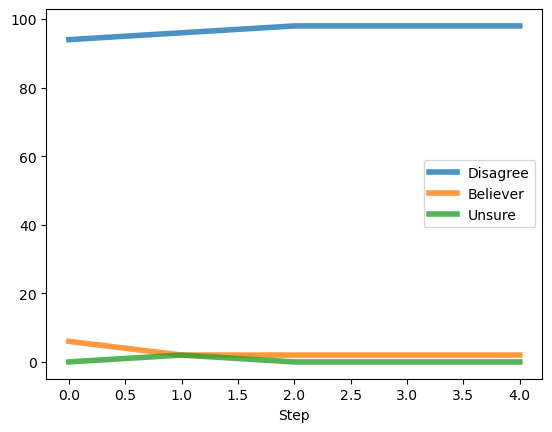

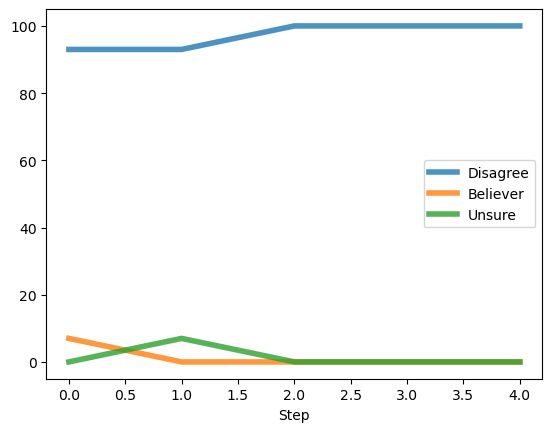

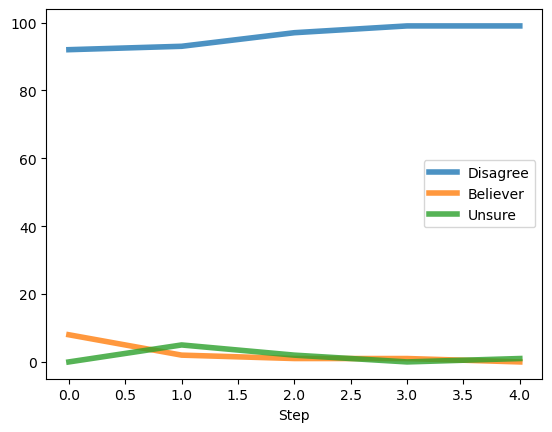

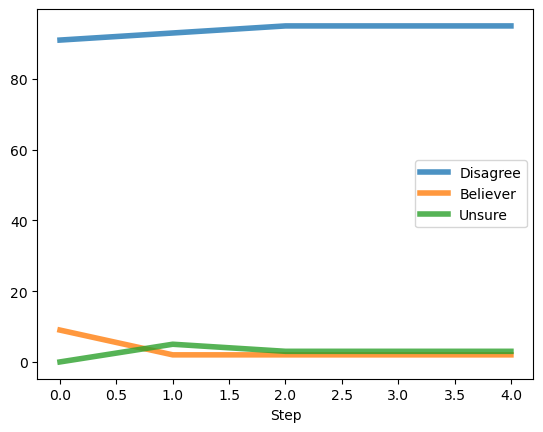

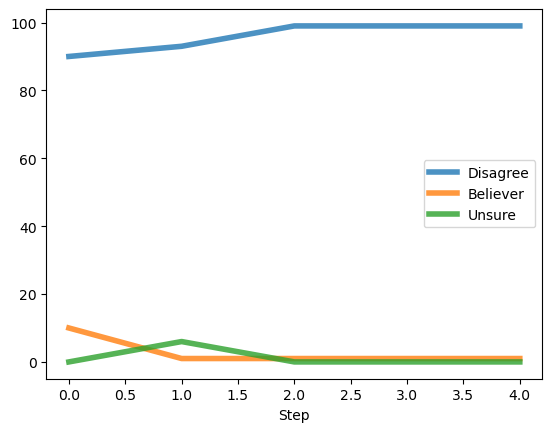

In [14]:
dim=[10,2]
a=np.zeros(dim)
population_size = 100
ratio_initial_believers_populationsize = 1/100
percentage_initial_believers= 0
avg_node_degree = 3
p_opinion_change = 1
for i in range(dim[0]):
    percentage_initial_believers= percentage_initial_believers+1
    n_initial_believers_c = percentage_initial_believers * population_size * ratio_initial_believers_populationsize
    def initiate_and_run_model(steps):

        model = network_model(population_size = 100, n_initial_believers = int(n_initial_believers_c), avg_node_degree = 3, p_opinion_change = 1)
    
        for i in range(steps):
            model.step()
    
        return model

    model = initiate_and_run_model(5)
    plot_agent_opinion(model)


In [15]:
dim=[100,2]
a=np.zeros(dim)
population_size_c = 100
ratio_initial_believers_populationsize = 1/100
percentage_initial_believers= 0
avg_node_degree = 3
p_opinion_change = 1
n_steps=4
for i in range(dim[0]):
    percentage_initial_believers= percentage_initial_believers+1
    n_initial_believers_c = percentage_initial_believers * population_size * ratio_initial_believers_populationsize
    def initiate_and_run_model(steps):

        model = network_model(population_size=int(population_size_c), n_initial_believers = int(n_initial_believers_c), avg_node_degree = 3, p_opinion_change = 1)
    
        for i in range(steps):
            model.step()
    
        return model

    model = initiate_and_run_model(n_steps)
    X = sum_agents(model)
    Y=X.values.tolist()
    a[i,0]=int(n_initial_believers_c)
    a[i,1]=int(Y[n_steps-1][0])
    #plot_agent_opinion(model) #if u want to see still time evolution
print(a)

[[  1. 100.]
 [  2. 100.]
 [  3. 100.]
 [  4. 100.]
 [  5. 100.]
 [  6. 100.]
 [  7. 100.]
 [  8.  99.]
 [  9.  97.]
 [ 10.  99.]
 [ 11.  97.]
 [ 12.  96.]
 [ 13.  93.]
 [ 14.  83.]
 [ 15.  96.]
 [ 16.  97.]
 [ 17.  97.]
 [ 18.  96.]
 [ 19.  83.]
 [ 20.  92.]
 [ 21.  94.]
 [ 22.  84.]
 [ 23.  85.]
 [ 24.  89.]
 [ 25.  95.]
 [ 26.  94.]
 [ 27.  80.]
 [ 28.  93.]
 [ 29.  39.]
 [ 30.  81.]
 [ 31.  78.]
 [ 32.  66.]
 [ 33.  68.]
 [ 34.  58.]
 [ 35.  57.]
 [ 36.  85.]
 [ 37.  79.]
 [ 38.  65.]
 [ 39.  76.]
 [ 40.  49.]
 [ 41.  77.]
 [ 42.  38.]
 [ 43.  59.]
 [ 44.  52.]
 [ 45.  67.]
 [ 46.  85.]
 [ 47.  34.]
 [ 48.  36.]
 [ 49.  41.]
 [ 50.  32.]
 [ 51.  37.]
 [ 52.  69.]
 [ 53.  53.]
 [ 54.  35.]
 [ 55.  16.]
 [ 56.  27.]
 [ 57.  30.]
 [ 58.  29.]
 [ 59.  17.]
 [ 60.  19.]
 [ 61.  17.]
 [ 62.  16.]
 [ 63.  29.]
 [ 64.  18.]
 [ 65.   7.]
 [ 66.  16.]
 [ 67.   7.]
 [ 68.  22.]
 [ 69.  16.]
 [ 70.  20.]
 [ 71.   7.]
 [ 72.   6.]
 [ 73.   7.]
 [ 74.  12.]
 [ 75.   2.]
 [ 76.   3.]
 [ 77.   6.]

### iteration from 1 to 100% initial believers. 5 times for data point. we plot the avarege.

[[1000.  997.  995. 1000.  995.]
 [ 992.  998.  995.  994. 1000.]
 [ 990.  993.  996.  985.  984.]
 [ 992.  976.  994.  983.  990.]
 [ 994.  984.  986.  992.  988.]
 [ 985.  993.  978.  986.  987.]
 [ 988.  983.  988.  968.  984.]
 [ 971.  986.  987.  983.  984.]
 [ 985.  971.  975.  962.  968.]
 [ 960.  968.  976.  959.  973.]
 [ 969.  977.  958.  970.  981.]
 [ 961.  980.  963.  969.  961.]
 [ 927.  933.  948.  969.  974.]
 [ 963.  972.  960.  946.  963.]
 [ 951.  934.  957.  947.  936.]
 [ 936.  940.  927.  921.  960.]
 [ 944.  935.  945.  949.  909.]
 [ 900.  951.  914.  917.  938.]
 [ 928.  943.  923.  932.  874.]
 [ 891.  921.  930.  892.  919.]
 [ 899.  918.  897.  866.  890.]
 [ 886.  916.  894.  890.  895.]
 [ 854.  849.  915.  887.  865.]
 [ 907.  875.  901.  862.  876.]
 [ 829.  885.  879.  879.  874.]
 [ 809.  878.  845.  856.  866.]
 [ 890.  838.  827.  849.  825.]
 [ 805.  849.  855.  837.  799.]
 [ 775.  854.  843.  817.  743.]
 [ 789.  815.  842.  855.  772.]
 [ 810.  8

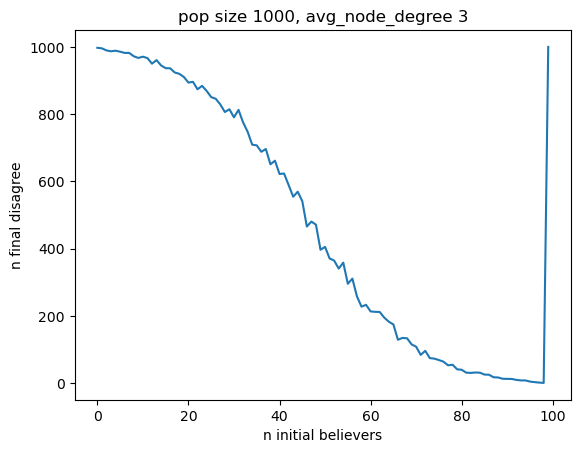

In [26]:
dim=[100,5]
a=np.zeros(dim)
population_size_c = 1000
ratio_initial_believers_populationsize = 1/100
percentage_initial_believers= 0
avg_node_degree_c = 3
p_opinion_change = 1
n_steps=4
for i in range(dim[0]):
    percentage_initial_believers= percentage_initial_believers+1
    n_initial_believers_c = percentage_initial_believers * population_size_c * ratio_initial_believers_populationsize
    for j in range(dim[1]):
        
        def initiate_and_run_model(steps):

            model = network_model(population_size=int(population_size_c), n_initial_believers = int(n_initial_believers_c), avg_node_degree = int(avg_node_degree_c), p_opinion_change = 1)
    
            for k in range(steps):
                model.step()
    
            return model

        model = initiate_and_run_model(n_steps)
        X = sum_agents(model)
        Y=X.values.tolist()
        a[i,j]=int(Y[n_steps-1][0])
        #plot_agent_opinion(model) #if u want to see still time evolution
print(a)
b=np.arange(0, 100, dtype=int)
c=np.mean(a,axis=1)
dim=[np.size(c,0),2]
resultsmatrix=np.zeros(dim)
resultsmatrix[:,0]=b
resultsmatrix[:,1]=c
print(resultsmatrix)
plt.plot(resultsmatrix[:,0],resultsmatrix[:,1]) 
plt.title("pop size " + str(population_size_c) + ", avg_node_degree " + str(avg_node_degree_c)) 
plt.xlabel("n initial believers") 
plt.ylabel("n final disagree")
plt.show()

### same conditions but more connected


[[1000. 1000.  999. 1000. 1000.]
 [1000.  999. 1000. 1000. 1000.]
 [1000.  999. 1000.  997.  998.]
 [1000. 1000.  998.  999. 1000.]
 [1000.  999. 1000.  997.  994.]
 [ 999.  994.  974.  998. 1000.]
 [1000.  995.  995.  995.  992.]
 [ 997.  999.  986.  989.  994.]
 [ 990.  991.  998.  999.  992.]
 [ 997.  996.  984.  990.  981.]
 [ 975.  992.  994.  971.  977.]
 [ 966.  986.  973.  978.  978.]
 [ 986.  978.  990.  998.  990.]
 [ 970.  979.  997.  981.  971.]
 [ 969.  995.  988.  987.  985.]
 [ 999.  984.  967.  982.  969.]
 [ 957.  982.  969.  953.  981.]
 [ 961.  960.  987.  981.  968.]
 [ 959.  962.  963.  963.  925.]
 [ 961.  965.  907.  934.  973.]
 [ 955.  938.  908.  931.  936.]
 [ 955.  978.  889.  980.  959.]
 [ 944.  964.  928.  940.  929.]
 [ 932.  933.  937.  959.  960.]
 [ 941.  907.  938.  947.  895.]
 [ 874.  977.  885.  906.  899.]
 [ 899.  958.  927.  947.  931.]
 [ 929.  855.  899.  911.  894.]
 [ 903.  916.  906.  918.  899.]
 [ 887.  913.  937.  865.  902.]
 [ 929.  8

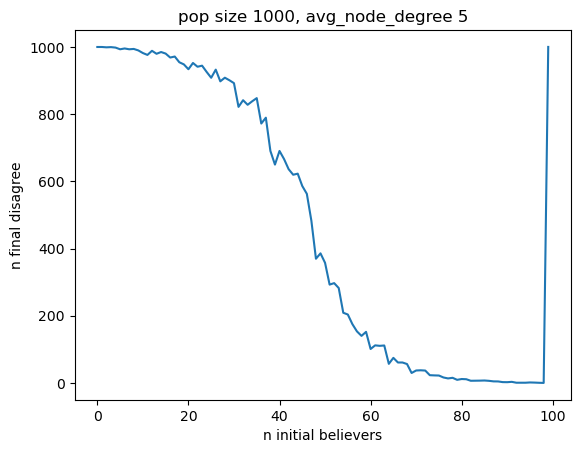

In [27]:
dim=[100,5]
a=np.zeros(dim)
population_size_c = 1000
ratio_initial_believers_populationsize = 1/100
percentage_initial_believers= 0
avg_node_degree_c = 5
p_opinion_change = 1
n_steps=4
for i in range(dim[0]):
    percentage_initial_believers= percentage_initial_believers+1
    n_initial_believers_c = percentage_initial_believers * population_size_c * ratio_initial_believers_populationsize
    for j in range(dim[1]):
        
        def initiate_and_run_model(steps):

            model = network_model(population_size=int(population_size_c), n_initial_believers = int(n_initial_believers_c), avg_node_degree = int(avg_node_degree_c), p_opinion_change = 1)
    
            for k in range(steps):
                model.step()
    
            return model

        model = initiate_and_run_model(n_steps)
        X = sum_agents(model)
        Y=X.values.tolist()
        a[i,j]=int(Y[n_steps-1][0])
        #plot_agent_opinion(model) #if u want to see still time evolution
print(a)
b=np.arange(0, 100, dtype=int)
c=np.mean(a,axis=1)
dim=[np.size(c,0),2]
resultsmatrix=np.zeros(dim)
resultsmatrix[:,0]=b
resultsmatrix[:,1]=c
print(resultsmatrix)
plt.plot(resultsmatrix[:,0],resultsmatrix[:,1]) 
plt.title("pop size " + str(population_size_c) + ", avg_node_degree " + str(avg_node_degree_c)) 
plt.xlabel("n initial believers") 
plt.ylabel("n final disagree")
plt.show()